# Skill Gap Analysis

#### This notebook identifies skill gaps between specific roles and the overall market.

### Load and Prepare Data

In [1]:
import pandas as pd
import ast
from collections import Counter

df = pd.read_csv("/content/combined_with_skills_norm_v1.csv")

/tmp/ipython-input-209977548.py:5: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/combined_with_skills_norm_v1.csv")


In [2]:
def parse_skills(x):
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except:
            return []
    return []

df["skills_norm"] = df["skills_norm"].apply(parse_skills)


In [3]:
df = df[df["skills_norm"].apply(len) > 0]
df.shape

(69146, 15)

### Standardize Role Titles

In [4]:
def map_role(title):
    if not isinstance(title, str):
        return "Other"
    t = title.lower()
    if "data scientist" in t:
        return "Data Scientist"
    if "data analyst" in t:
        return "Data Analyst"
    if "machine learning" in t:
        return "ML Engineer"
    if "backend" in t:
        return "Backend Engineer"
    if "frontend" in t:
        return "Frontend Engineer"
    if "software engineer" in t or "software developer" in t:
        return "Software Engineer"
    return "Other"

df["role_group"] = df["job_title"].apply(map_role)


In [5]:
df["role_group"].value_counts()

,count
role_group,
Other,66479
Software Engineer,1580
Data Analyst,365
Data Scientist,290
ML Engineer,177
Backend Engineer,151
Frontend Engineer,104


### Compute global skill distribution

In [6]:
all_skills = [skill for skills in df["skills_norm"] for skill in skills]
global_counts = Counter(all_skills)

global_skill_dist = (
    pd.DataFrame(global_counts.items(), columns=["skill", "global_count"])
    .sort_values("global_count", ascending=False)
)

global_total = global_skill_dist["global_count"].sum()
global_skill_dist["global_pct"] = global_skill_dist["global_count"] / global_total


### Compute role-specific skill distribution

In [7]:
TARGET_ROLE = "Data Scientist"

df_role = df[df["role_group"] == TARGET_ROLE]

In [8]:
role_skills = [skill for skills in df_role["skills_norm"] for skill in skills]
role_counts = Counter(role_skills)

role_skill_dist = (
    pd.DataFrame(role_counts.items(), columns=["skill", "role_count"])
    .sort_values("role_count", ascending=False)
)

role_total = role_skill_dist["role_count"].sum()
role_skill_dist["role_pct"] = role_skill_dist["role_count"] / role_total


### Compute skill gap

In [9]:
skill_gap = pd.merge(
    role_skill_dist,
    global_skill_dist,
    on="skill",
    how="left"
)

In [10]:
skill_gap["gap"] = skill_gap["role_pct"] - skill_gap["global_pct"]

In [11]:
skill_gap = skill_gap.sort_values("gap", ascending=False)
skill_gap.head(10)

,skill,role_count,role_pct,global_count,global_pct,gap
0,python,258,0.197399,5274,0.046793,0.150605
1,machine learning,210,0.160673,1897,0.016831,0.143842
2,sql,185,0.141546,6322,0.056092,0.085454
6,deep learning,58,0.044376,313,0.002777,0.041599
8,pytorch,52,0.039786,281,0.002493,0.037293
9,tensorflow,44,0.033665,260,0.002307,0.031358
7,tableau,56,0.042846,1388,0.012315,0.030531
10,nlp,42,0.032135,238,0.002112,0.030023
12,gcp,28,0.021423,1158,0.010274,0.011149
14,docker,25,0.019128,1188,0.010541,0.008587


## Visualize top positive & negative gaps

In [12]:
import matplotlib.pyplot as plt

### Top overrepresented skills

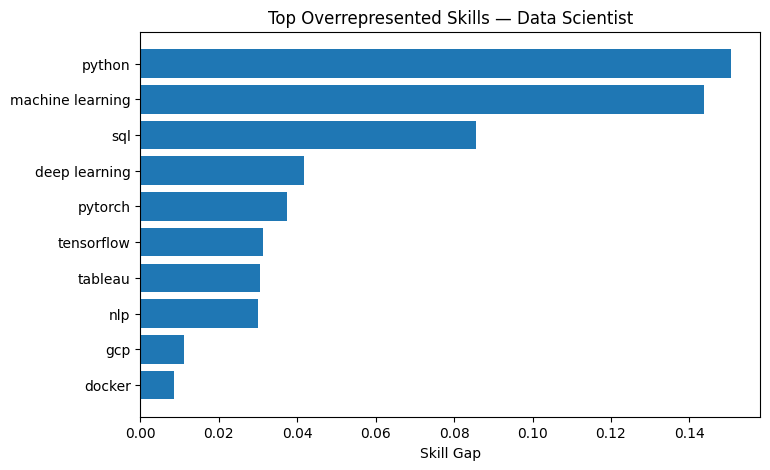

In [16]:
top_positive = skill_gap.head(10)

plt.figure(figsize=(8,5))
plt.barh(top_positive["skill"], top_positive["gap"])
plt.title(f"Top Overrepresented Skills — {TARGET_ROLE}")
plt.xlabel("Skill Gap")
plt.gca().invert_yaxis()
plt.savefig("overrepresented_skills_data_scientist.png", bbox_inches="tight")
plt.show()

### Top missing / underrepresented skills

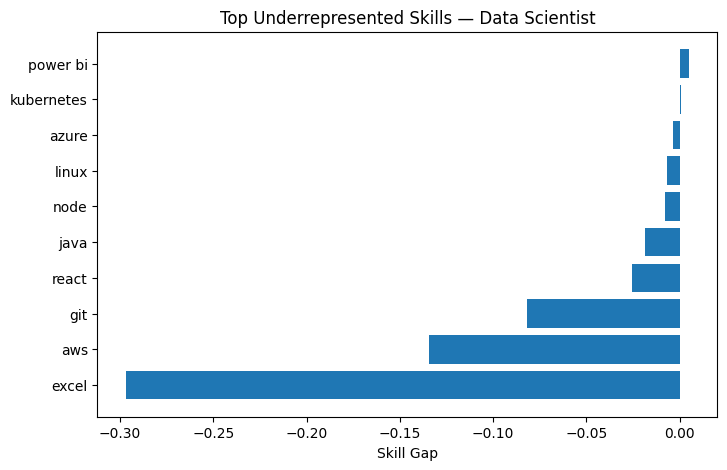

In [17]:
top_negative = skill_gap.tail(10)

plt.figure(figsize=(8,5))
plt.barh(top_negative["skill"], top_negative["gap"])
plt.title(f"Top Underrepresented Skills — {TARGET_ROLE}")
plt.xlabel("Skill Gap")
plt.gca().invert_yaxis()
plt.savefig("underrepresented_skills_data_scientist.png", bbox_inches="tight")
plt.show()

## Interpretation

- Python shows the highest positive gap, confirming it is a baseline requirement rather than a differentiator for Data Scientist roles.

- Machine Learning and SQL are also overrepresented, indicating strong saturation in candidate skill profiles.

- Excel has the largest negative gap, suggesting it is commonly listed but provides little competitive advantage for Data Scientist positions.

- Cloud and engineering tools (AWS, Git, React, Java) appear moderately underrepresented, implying potential leverage areas for differentiation.

- Advanced tools like Kubernetes, Power BI, and Linux are niche and weakly represented, likely relevant only for specific hybrid roles.